# Iterative_Adversarial_Generation

Author: Shiyuan Duan

Date: 05/15/2020

## Introduction
This project extends the FGSM methods. The original FGSM method is a one-time, non-targeted attack. In this project, I explore the possibility of generating a targeted adversarial attack image. The goal is to calculate a small perturbation so that when it is added to the original image, the image gets misclassified into a targeted class.

In [8]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.autograd import Variable
import torch.nn.functional as F

from tqdm import tqdm


plt.ion()   # interactive mode

## Step 1: Train/Test data preparation

In [9]:

data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Load training data
trainset_dir = './animal_data/train'
trainset = datasets.ImageFolder(trainset_dir, transform=data_transform)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 4)

dataset_sizes = len(trainset)
class_names = trainset.classes

resnet = models.resnet18(pretrained=False)
in_feature = resnet.fc.in_features
resnet.fc = nn.Linear(in_feature, 4)
resnet.load_state_dict(torch.load('./cifar_net.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


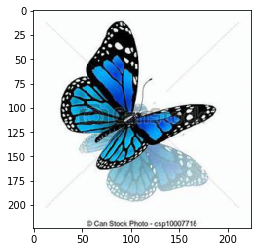

In [10]:
# Load a test image
test_dir = './animal_data/test'
testset = datasets.ImageFolder(test_dir, transform=data_transform)
# Note that the batch size here is one because we only want to perform adversarial attack on one image
testset_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)

image, label = next(iter(testset_loader))

def single_imshow(image):
    #Takes in a numpy
    img = image[0].transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    plt.imshow(img)
    plt.show()
    
single_imshow(image.numpy())

### Target Image visualization

In [11]:
# Test our prediction
image = image.to(device)
label = label.to(device)

resnet = resnet.to(device)

outputs = resnet(image)
_, pred = torch.max(outputs, 1)
print("Prediction: "+class_names[pred])
    

Prediction: butterflies


## Step 2: Adversarial Attack

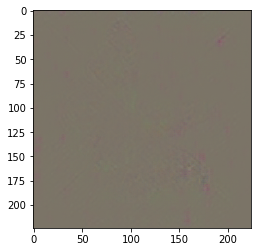

In [12]:
for param in resnet.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
## Perform targeted FGSM
iter_num = 20000
purt_lr = 1e-2
loss = 10
i = 0

original_img = image


initial_class = 0
pred = initial_class
target_class = 3
image_save = Variable(torch.zeros(image.size()))

## Calculate purtubation to add to the original image so that resnet classifies it as horse
purt_init = Variable(torch.zeros(image.size()))
resnet = resnet.to(device)
while(pred != target_class):
    i += 1
    purt = Variable(purt_init.data.cuda(), requires_grad = True)
    purt = purt.to(device)
    purt_img = purt
    
    
    #purt = (purt - purt.mean())/purt.std()
    #purt.retain_grad()
    image_purt = image.to(device)+purt.to(device)
    
    #image = image_purt
    image_save = image_purt
    # Change the desired class to horses
    label[0] = target_class
    
    outputs = resnet(image_purt)
    
    _, pred = torch.max(outputs, 1)
    
    #print(criterion(outputs, label) - image)
    label = label.to(device)
    loss = criterion(outputs, label) + 0.1*purt.norm()
    if i%1000 == 0:
        single_imshow(purt.detach().cpu().numpy())
        
    loss.backward()
    purt_init = purt - purt_lr*(purt.grad.data/purt.grad.data.norm())
    purt.grad.zero_()
    
    

### Image after adversarial attack

The image below is an purterbed image. It is very hard for human to detect the perturbation if the background is complicated. Here I am choosing an image with a white backgroud for demenstration purpose. The image below is classified as horse, as desired.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


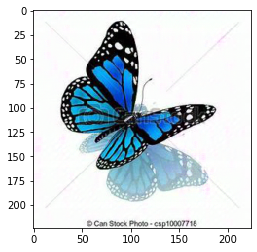

In [13]:
single_imshow(image_save.detach().cpu().numpy())

In [16]:
outputs = resnet(image_save)
    
_, pred = torch.max(outputs, 1)
print("Image is classified as: ",class_names[pred])

Image is classified as:  horses
